# Machine Learning for Heat-pump Power Estimation

## Introduction to heat-pump

## Why Heat-pump?

Heat pumps are becoming increasingly popular as a way to heat and cool homes and buildings. Here are some reasons why we should move towards the use of heat pumps:
1.	Energy Efficiency: Heat pumps are highly energy efficient compared to traditional heating and cooling systems, such as furnaces and old air conditioners. They can provide up to four times the amount of energy they consume, making them a more cost-effective option in the long run.
2.	Lower Environmental Impact: Heat pumps have a lower environmental impact than traditional heating and cooling systems. They produce fewer greenhouse gas emissions and use less fossil fuels, helping to reduce carbon footprint.
3.	Versatility: Heat pumps can provide both heating and cooling, making them a versatile option for all seasons. They can also be used for domestic hot water production.
4.	Improved Indoor Air Quality: Heat pumps do not burn fuel, which means there is no combustion, which in turn means no indoor air pollution. This leads to improved indoor air quality and a healthier living environment.
5.	Long Lifespan: Heat pumps have a long lifespan compared to traditional heating and cooling systems, making them a more durable and reliable option.
6.	Lower Maintenance Costs: Heat pumps require less maintenance than traditional heating and cooling systems, as they have fewer mechanical parts that can wear out or break down.

Overall, heat pumps are a highly efficient and cost-effective option for heating and cooling homes and buildings, while also providing benefits to the environment and indoor air quality.


## What is Heat-pump?

A heat pump is a heating and cooling system that moves heat from one place to another. It uses a small amount of energy to move heat from the air or ground outside a building to the inside, or from the inside to the outside, depending on the season.

In the winter, a heat pump absorbs heat from the outdoor air, even in cold temperatures, and transfers it inside to warm the building. In the summer, the process is reversed, and heat is transferred from the inside to the outside to cool the building.


### General refrigerant circuit

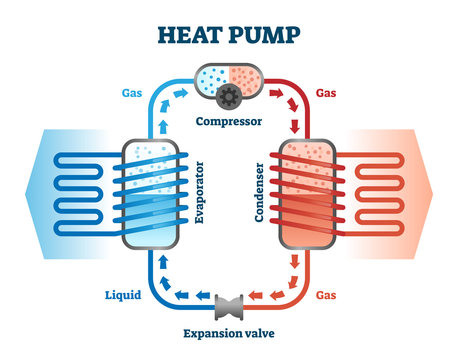


### Heat-pump types

- air-to-air,
- air-to-water,
- water-to-water (ground-source).

### Space heating and domestic hot water circuit for air-to-water

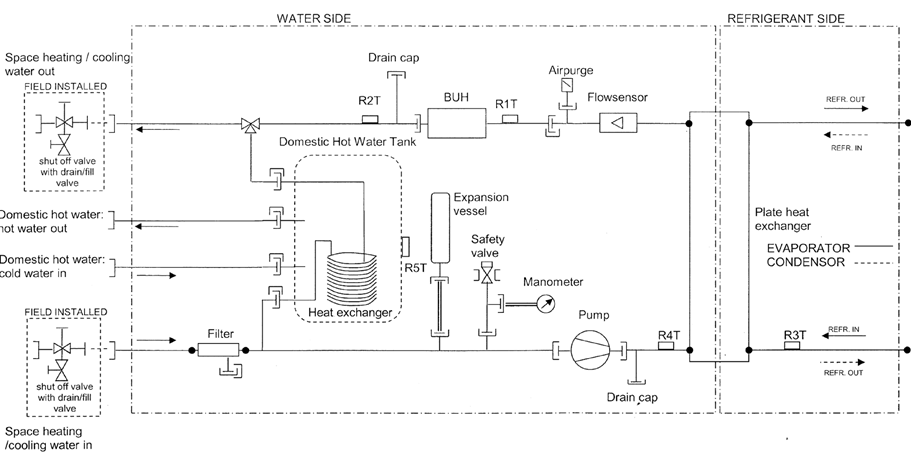

## Machine Learning

Machine learning is a subset of artificial intelligence that involves training algorithms to learn from data and make predictions or decisions without being explicitly programmed.

In other words, instead of programming rules directly, machine learning algorithms are given large amounts of data and use statistical methods to learn patterns and relationships within the data. These patterns can then be used to make predictions or decisions about new, unseen data.

We need to use machine learning because it enables us to build intelligent systems that can make predictions, recognize patterns, and automate decision-making processes. This has many practical applications, such as in image and speech recognition, natural language processing, recommender systems, fraud detection, and more.

Machine learning can also help businesses and organizations gain insights from large amounts of data, improve processes, and optimize performance. By automating routine tasks and identifying patterns that humans may miss, machine learning can help to save time, reduce costs, and improve accuracy in various domains.

## Problem definition

We want to find the average daily electrical consumption for space heating in an air-to-water heat-pump as a function of other measured items as ambient temperature and room temperature. 


$\textbf{Note:}$ The electrical consumption consists of 3 main values:
- Heat-pump (mainy compressor and the most favorite as it comes with higher COPs~3)
- Back-up-heater (purely resistance heating of the water with COP=1)
- Booster-heater (another resistance heating)  [ZERO FOR OUR CASE]


For this, we use real data from one field-site.

## Code

### Imports

In [1]:
from pathlib import Path
import os
import pandas as pd
import plotly.express as px 
from datetime import datetime as dt
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.linear_model import LinearRegression

### Data preparation

#### Reading data

Here, we read one of our field-sites' data. The format is CSV. 

In [2]:
data_folder = os.path.join(Path(os.getcwd()).parent, 'data')
csvfiles = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
save_to_excel = False
index_file_to_read = 0 #  case 1


data = pd.read_csv(csvfiles[index_file_to_read], low_memory=False)
if save_to_excel:
    data.to_excel(f[:-3]+'xlsx')

    

#### Data manipulation

We do some data check and NaN droping (for case 1 there are only two NaN values). Then, we rename the columns, and finally we add a column to have dates from timestamps ($ns$).

In [3]:
data1 = data.copy()
data1.loc[:, 'date'] = [dt.fromtimestamp(float(x)/1000) for x  in data1['timestamp']]

In [4]:
print(data1.columns)

Index(['ambient_temp', 'buh_elec_input_kw', 'hp_elec_input_kw',
       'rt_sp_heating', 'rt_temp', 'status_3wv', 'timestamp', 'date'],
      dtype='object')


#### Input/Outputs

Here, we prepare our input and outputs. 

The inputs are:
- Room temperature (where the thermostat is located)
- Ambient Temperature (where outdoor unit is located)
- Setpoint (The setpoint the room needs to reach to; read by thermostat)
- 3-way-valve (it is is 1 then we have domestic hot water and when it is 0 space-heating operation is ongoing).

And the outputs are:
- Heat-pump electrical power consumption
- Back-up-heater electrical power consumption


In [5]:
input_cols = ['date', # date 
              'rt_temp', # room temperature
              'ambient_temp', # ambient temperature
              'rt_sp_heating', # setpoint
              'status_3wv'] # status_3wv==1 then domestic hot water is active 
                            # status_3wv==0 then space heating is active 


output_cols = [col for col in data1.columns if 'input_kw' in col]  


data_ml = data1[input_cols+output_cols]
data_ml = data_ml.set_index('date').astype(float)


print(data_ml.head(10))
print('-'*20)
print(data_ml.tail(10))

                           rt_temp  ambient_temp  rt_sp_heating  status_3wv  \
date                                                                          
2022-03-06 01:50:50.343  24.299999           3.5           23.5         0.0   
2022-03-06 01:51:00.979  24.299999           3.5           23.5         0.0   
2022-03-06 01:51:10.997  24.299999           3.5           23.5         0.0   
2022-03-06 01:51:21.330  24.299999           3.5           23.5         0.0   
2022-03-06 01:51:31.334  24.299999           3.5           23.5         0.0   
2022-03-06 01:51:42.981  24.299999           3.5           23.5         0.0   
2022-03-06 01:51:52.987  24.299999           3.5           23.5         0.0   
2022-03-06 01:52:03.335  24.299999           3.5           23.5         0.0   
2022-03-06 01:52:14.998  24.299999           3.5           23.5         0.0   
2022-03-06 01:52:25.001  24.299999           3.5           23.5         0.0   

                         buh_elec_input_kw  hp_elec

#### Resample

In [6]:
data_ml_resampled = data_ml.resample('24H').mean()

#### Drop Na

In [7]:
data_ml_resampled = data_ml_resampled.dropna()

#### Plots

<AxesSubplot: xlabel='date'>

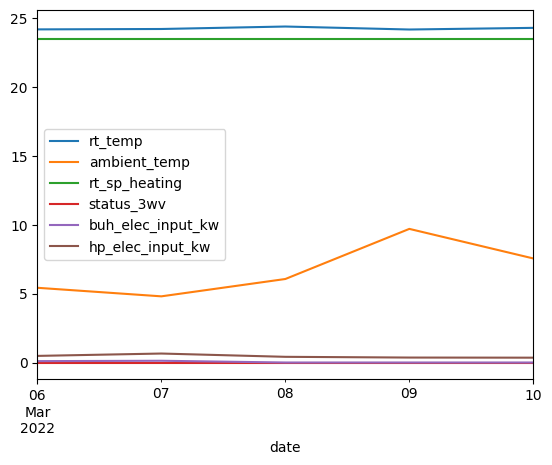

In [8]:
data_ml_resampled['2022-03-06':'2022-03-10'].plot()

#### Train/Test data separation

In [9]:
# create train test partition
data_train = data_ml_resampled['2022-03-06':'2022-03-10']
data_test  = data_ml_resampled['2022-03-16':]
print('-'*20)
print(data_train.head())

print('-'*20)
print(data_test.head())


--------------------
              rt_temp  ambient_temp  rt_sp_heating  status_3wv  \
date                                                             
2022-03-06  24.194215      5.427978           23.5         0.0   
2022-03-07  24.222421      4.806659           23.5         0.0   
2022-03-08  24.402094      6.065924           23.5         0.0   
2022-03-09  24.185075      9.705558           23.5         0.0   
2022-03-10  24.305040      7.557358           23.5         0.0   

            buh_elec_input_kw  hp_elec_input_kw  
date                                             
2022-03-06           0.100586          0.480858  
2022-03-07           0.127749          0.652631  
2022-03-08           0.000000          0.414019  
2022-03-09           0.000000          0.360636  
2022-03-10           0.000000          0.352115  
--------------------
              rt_temp  ambient_temp  rt_sp_heating  status_3wv  \
date                                                             
2022-03-16  2

In [10]:
power_to_estimate = 'hp'
power_ind = 0 if power_to_estimate=='buh' else 1 if power_to_estimate=='hp' else 0

x_train, y_train = data_train.iloc[:, [0,1,3]].values, data_train[output_cols[power_ind]].values
x_test, y_test = data_train.iloc[:,[0,1,3]].values, data_train[output_cols[power_ind]].values


In [11]:
print(output_cols[power_ind])

hp_elec_input_kw


#### Machine learning

In [12]:
model = LinearRegression().fit(x_train, y_train)

In [13]:
r_2 = model.score(x_train, y_train)
print(f"coefficient of determination: {r_2}")

coefficient of determination: 0.7775348448302216


In [14]:
y_pred = model.predict(x_test)

Text(0.5, 1.0, 'Estimation of Power base on indoor and ambient temperatures ')

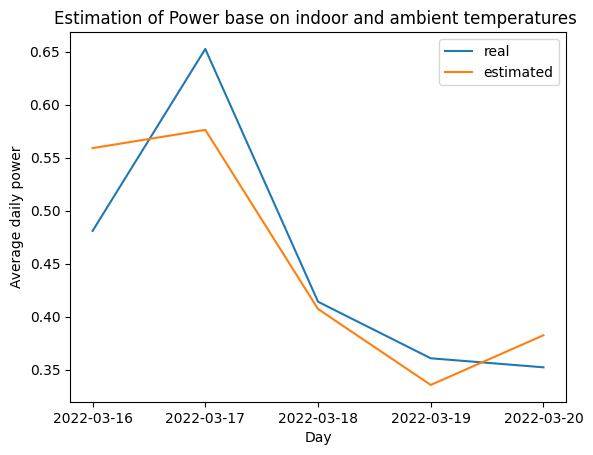

In [15]:
str_x = data_test.index[0:len(y_test)].astype(str)
fig, ax = plt.subplots()
ax.plot(str_x, y_test)
ax.plot(str_x, y_pred)
ax.set_ylabel('Average daily power')
ax.set_xlabel('Day')
#ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.legend(['real', 'estimated'])
ax.set_title('Estimation of Power base on indoor and ambient temperatures ')